In [ ]:
ica_folder = "ica_dir"

In [ ]:
experiments_list1 = [
                    "mouse1_ex1",
#                    "mouse1_ex2",
#                    "mouse1_ex3",
                    ]
mouse_id1 = "mouse1"

experiments_list2 = [
                    "mouse2_ex1",
#                    "mouse2_ex2",
#                    "mouse2_ex3",
                    ]
mouse_id2 = "mouse2"

experiments_list3 = [
                    "mouse3_ex1",
#                    "mouse3_ex2",
#                    "mouse3_ex3",
                    ]
mouse_id3 = "mouse3"


ex_list = [
            experiments_list1,
            experiments_list2, 
            experiments_list3,  
                ]

mouse_list = [
              mouse_id1,
              mouse_id2,
              mouse_id3,  
                ]

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff):

    order = 4  
    nyquist = 0.5 * fs  
    normal_cutoff = cutoff / nyquist  # normalized cut-off frequency

    # Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # applying
    filtered_data = filtfilt(b, a, data)

    return filtered_dat

In [4]:
import numpy as np

def z_score(data, start_n, end_n):

    z_data = (data-np.mean(data[start_n:end_n])) / np.std(data[start_n:end_n])
    
    return z_data

In [ ]:
import numpy as np
import tqdm

hemo_folder = "hemo-corrected_dir"
fs = 20  # sampling rate
cortex_cutoff = 2  # cut-off frequency
no_cycle = 10
vis_stim1 = 15   # stimulation start (sec)
#vis_stim2 = 25
use_range = 5  # range (sec)


ca_datas = []
for mouse in tqdm.tqdm(range(len(mouse_list))):
    img_path = f"{hemo_folder}/img/{mouse_list[mouse]}"
    roi_path = f"{hemo_folder}/roi/{mouse_list[mouse]}"

    ca_data = []
    for ex in tqdm.tqdm(range(len(ex_list[mouse]))):
        ca_data1 = []
        for cycle in range(no_cycle):
            cycle_ca =  np.load(f"{img_path}/{ex_list[mouse][ex]}/{ex_list[mouse][ex]}_ex0{cycle}.npy")

            for y in range(cycle_ca.shape[1]):
                for x in range(cycle_ca.shape[2]):
                    if not cycle_ca[0, y, x] == 0:
                        temp_z = z_score(data=cycle_ca[:, y, x], start_n=20, end_n=90)
                        cycle_ca[:, y, x] = temp_z


            cycle_ca1 = cycle_ca[int(fs*vis_stim1)-int(fs*use_range):int(fs*vis_stim1)+int(fs*use_range)]
            #cycle_ca2 = cycle_ca[int(fs*vis_stim2)-int(fs*use_range):int(fs*vis_stim2)+int(fs*use_range)]


            ca_data1.append(cycle_ca1)
            #ca_data2.append(cycle_ca2)

        #ca_data1, ca_data2 = np.array(ca_data1), np.array(ca_data2)
        ca_data1 = np.array(ca_data1)
        #ca_data_n = np.concatenate((ca_data1, ca_data2), axis=0)
        ca_data_n = ca_data1
        #ca_data_n = np.concatenate((ca_data1.transpose(1, 0, 2), ca_data2.transpose(1, 0, 2)), axis=0)

        ca_data.append(ca_data_n)
    ca_datas.append(ca_data)

print(len(ca_datas[0]), ca_datas[0][0].shape)
print(len(ca_datas[1]), ca_datas[1][0].shape)
print(len(ca_datas[2]), ca_datas[2][0].shape)

100%|██████████| 3/3 [06:52<00:00, 137.54s/it]

4 (10, 200, 256, 270)
4 (10, 200, 256, 270)
4 (10, 200, 256, 270)


In [ ]:
ca_list = []
for mouse in tqdm.tqdm(range(len(mouse_list))):
    temp_ca = []
    for ex in range(len(ca_datas[mouse])):
        for cycle in range(len(ca_datas[mouse][ex])):
            temp_ca.append(ca_datas[mouse][ex][cycle])
    ca_list.append(temp_ca)
    

print(len(ca_list[0]), len(ca_list[1]), len(ca_list[2]))
print(ca_list[0][0].shape, ca_list[1][0].shape, ca_list[2][0].shape)

100%|██████████| 3/3 [00:00<00:00, 3020.38it/s]

40 40 40
(200, 256, 270) (200, 256, 270) (200, 256, 270)


In [8]:
del ca_datas

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
import tqdm

def normalize_svd(img_list, img_list2, n_components, svd_start, svd_end):

    extract_list = []
    for ex in range(len(img_list)):
        extract_list.append(img_list[ex][svd_start:svd_end])
    
    extract_list = np.array(extract_list)
    extract_array = np.concatenate(extract_list, axis=0)

    # reshape 3d to 2d
    reshaped_img = extract_array.reshape(extract_array.shape[0], -1)  # (frames, height*width)
    

    # do SVD
    U, S, VT = np.linalg.svd(reshaped_img, full_matrices=False)

    U = U[:, :n_components]   # (frames, n_components)
    S = S[:n_components]      # (n_components,)
    VT = VT[:n_components, :] # (n_components, height*width)

    u = VT

    uuT = u @ u.T               # shape (n_components, n_components)
    inv_uuT = np.linalg.inv(uuT)

    SVT = []
    for ex in tqdm.tqdm(range(len(img_list2))):
        reshaped_norm = img_list2[ex].reshape(img_list2[ex].shape[0], img_list2[ex].shape[1]*img_list2[ex].shape[2])
        svt = reshaped_norm @ u.T @ inv_uuT
        SVT.append(svt.T)     # shape (frames, n_components)
    SVT = np.array(SVT)

    U_space = u.T.reshape(extract_array.shape[1], extract_array.shape[2], n_components)  # (height*width, n_components) -> (height, width, n_components)

    return U_space, SVT, S

In [ ]:
import tqdm

components = 400  # n_components
svd_start, svd_end = 80, 120  # frame

U, SVT, S = normalize_svd(ca_list[0][::5] + ca_list[1][::5] + ca_list[2][::5], ca_list[0] + ca_list[1] + ca_list[2], components, svd_start, svd_end)

print(U.shape, SVT.shape, S.shape)

100%|██████████| 120/120 [00:03<00:00, 30.20it/s]

(256, 270, 400) (120, 400, 200) (400,)


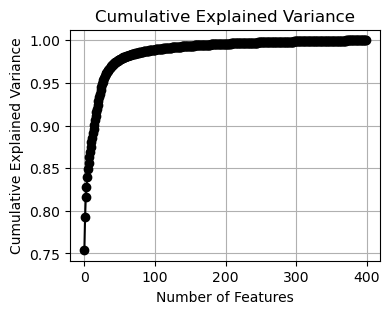

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

s = S
explained_variance = (s ** 2) / np.sum(s ** 2)

# Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance)

num_features = SVT.shape[1]
plt.figure(figsize=(4, 3))
plt.plot(range(0, components), cumulative_explained_variance[:components], marker='o', linestyle='-', color='black')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
np.save(f"{ica_folder}/u.npy", U)
np.save(f"{ica_folder}/svt.npy", SVT)
np.save(f"{ica_folder}/singular_value.npy", S)